Sections to Assignment
1) Exploratory Data Analysis __Wei__
- Add column for Land tags (see the weather tags for how to do this) - these should be Primary, Water and Other.
- Rebuild new correlation matrix to compare weather tags with Primary, Water and Other, and the primary water and other tags with each other
<br>
- write analysis about the data set
<br>
- Change example images so there is at least four of each weather example, and five images containing each of the primary, water and other tags

2) Image Processing and Extraction - __Elle__ <br>
a) Add additional  feature analysis
<br>
b) experiment with water extraction
<br>
c) Add frames explaining what each model does
<br>
d) Try haze removal
<br>

3) Weather Prediction Attempts- __Wei__ 
<br>
a) Set the train and Test Data up so a random sample of 35000 images are selected for testing each time
<br>
b) Build a pipeline so different models can be switched in and out - cross validation is essential
<br>
c) Try a variety of different models (at least four), and explain why and why they don't work. Output a confusion matrix, and comment on what the model is getting wrong
<br>
d) For the random forest model, try changing the parameters to improve performance
<br>
e) Show which features were important to the model __Elle__
<br>
<br>
4) Land Type Prediction - __Sai__
<br>
a) Build a pretty confusion matrix function that can be utilised throughout the whole document
<br>
b) Build a pipeline so different models can be switched in and out
<br>
c) Try a variety of different models (at least four), and explain why and why they don't work. Include confusion matrices
<br>
d) Try the PCA approach to see if some of the model can be reduced 
<br>
<br>
5) Mixed Model Approach - __Nick__ <br>
a) As per above use pipelines with cross validation and try a variety of models, please make sure to cover: classifier chains,
one vs rest and adapted algorithm approaches,
<br>
b) Play with the parameters of the model that worked the best
<br>
<br>
6) Conclusion/Model recommendation - __Elle__<br>
a) Write up which model worked the best and why <br>
b) Suggest alternative approaches
<br>
<br>
Other things to do:
a) Format the document with headers for each section/ensure that only essential libraries are listed up top - __Sai__
<br>
b) Try a neural net approach - __Elle__
<br>
c) Suggest appropriate metrics to try - __Nick__
<br>
d) Everyone to comment extensively on their own code/ b) fully explain what they're doing and analyse the results



Overview of Assignment
There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

Given we are mostly interested in being able to tell where deforestation is occuring, we will simplify the land tags into naturally occuring phenomena 



In [4]:
##Create Libraries
### Required libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter, defaultdict
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import scipy.stats
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)

import plotly.graph_objs as go
import plotly.tools as tls
import random
# from osgeo import gdal
#from skimage import io
import imageio
from spectral import get_rgb
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


In [7]:
##set path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'
print(test_path1)
#get labels
df = pd.read_csv('train_labels.csv')
#get jpg data - we're going to compress everything so it runs quickly.
data_jpgs=np.zeros((40000,64,64,3))

##retrieve Jpg Data
def read_image(image_str):
    #read_img = plt.imread(train_path1+image_str)
    read_img = imageio.imread(train_path1+image_str)
    read_img=read_img[:,:,:3]
    jpg_img=transform.resize(read_img, (64,64,3))
    return jpg_img
for i in range(40000):
    data_jpgs[i,:,:,:]=read_image("train_"+str(i)+".jpg")
    


test_jpg/


FileNotFoundError: No such file: 'C:\Users\sai.ravuru\PycharmProjects\MIDS\amazon_w207\train_jpg\train_0.jpg'

In [3]:
#retrieve TIF-Data
def extract_identifier(image_str):
    read_img = io.imread(train_path2+image_str)
    tif_img=transform.resize(read_img, (64,64,4))
    return tif_img

tif_data=np.zeros((40000,64,64,4))
for i in range(40000):
    tif_data[i,:,:,:]=extract_identifier("train_"+str(i)+".tif")


View some example images

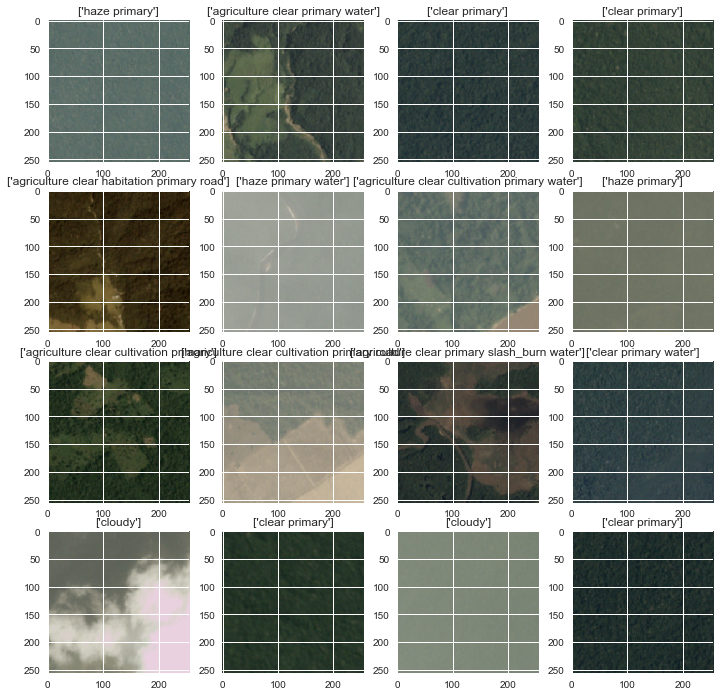

In [10]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(train_path1+"train_"+str(i)+".jpg"))
    plt.title(str(df[df.image_name == 'train_'+str(i)].tags.values))

There is a lot of variety in visibility between the images. Each picture has one or many labels. Cloudy appears not to contain any other tags. Water is sometimes hard to identify in the images.

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365 

There is 17 unique labels including {'slash_burn', 'haze', 'blooming', 'habitation', 'blow_down', 'water', 'agriculture', 'selective_logging', 'conventional_mine', 'primary', 'bare_ground', 'clear', 'cloudy', 'cultivation', 'artisinal_mine', 'partly_cloudy', 'road'} 



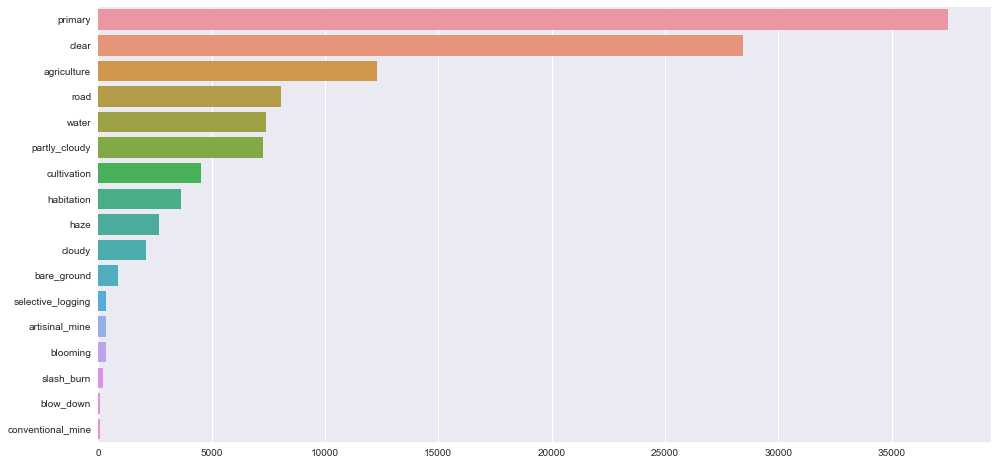

In [4]:
## View prominent tags and investigate correlations

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {} \n'.format(1.0*len(all_tags)/df.shape[0]))

labels_set = set(all_tags)
print("There is {} unique labels including {} \n".format(len(labels_set), labels_set))

labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [5]:
#Display correlation between labels 
labels = df['tags'].apply(lambda x: x.split(' '))
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

Everything is highly correlated with Primary, and also clear. This is because most images are clear, and most of the pictures contain forest. 

This suggests a highly unbalanced set. Interestingly we can see cloudly is almost never correlated with any other tags.

In [11]:
##for the first pass try to predict simpler tags only
def remove_tag(hard):
    hard_tags=['blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    easier_tags=hard.split()
    for i in hard_tags:
        try:
            easier_tags.remove(i)
        except:
            pass
    easier_tags=' '.join(easier_tags)
    return easier_tags
df['simpler_tags'] = df.tags.map(remove_tag)

##for the first pass try to predict simpler tags only
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)
df_tags = df['weather'].tolist()



There are total 40479 weather data


Given the features in this image move around - we need to extract information about the cells that won't be affected by their placement. We can do this by extracting volume of colours (trees surely contain lots of green, cells with clouds should contain lots of white, so lots of high pixel values).

Variance measures of the colours are probably important, because a cell that's all cloudy or all forest won't have much variance. 

In [12]:
##extract_basic-stats about image
stats_flat=np.reshape(data_jpgs,(data_jpgs.shape[0],4096,3))
jpg_stats=np.zeros((stats_flat.shape[0],75))
for i in range(stats_flat.shape[0]):
    jpg_stats[i,0:3]=np.average(stats_flat[i],axis=0)
    jpg_stats[i,3:6]=np.var(stats_flat[i],axis=0)
    jpg_stats[i,6:9]=np.std(stats_flat[i],axis=0)
    kurt_skew=np.zeros((6,))
    for j in range(3):
        kurt_skew[j]=scipy.stats.kurtosis(data_jpgs[i,:,:,j].ravel())
        kurt_skew[j]=scipy.stats.skew(data_jpgs[i,:,:,j].ravel())
    jpg_stats[i,9:15]=kurt_skew
    jpg_stats[i,15:35]=np.array(np.histogram(data_jpgs[1,:,:,0],bins=20, range=(0,1))[0])
    jpg_stats[i,35:55]=np.array(np.histogram(data_jpgs[1,:,:,1],bins=20, range=(0,1))[0])
    jpg_stats[i,55:75]=np.array(np.histogram(data_jpgs[1,:,:,2],bins=20, range=(0,1))[0])

In [ ]:
##extract edge data from images
edge_stats=np.zeros((stats_flat.shape[0],6))
for i in range(stats_flat.shape[0]):
    edge_stats[i,0]=cv2.Laplacian(data_jpgs[i], cv2.CV_64F).mean()
    edge_stats[i,1]=cv2.Laplacian(data_jpgs[i], cv2.CV_64F).var()
    edge_stats[i,2]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,1,0,ksize=5).var()
    edge_stats[i,3]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,1,0,ksize=5).mean()
    edge_stats[i,4]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,0,1,ksize=5).mean()
    edge_stats[i,5]=cv2.Sobel(data_jpgs[i],cv2.CV_64F,0,1,ksize=5).var()

Now - let's look at the TIF images, which also contain infrared information. This is helpful because it contains infrared light which helps us identify features which can't be split with natural light.

Essentially we can tell if something is likely to be water by substracting the infrared light from the blue light, and dividing by sum.

The same can be said for vegetation.

The two formulas are (B-IRR)/(B+IRR) = index for water (IRR-R)/(R+IRR) = index for vegetation

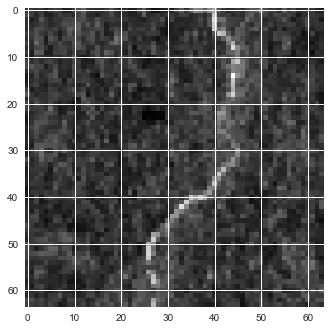

In [13]:
#extract, vegetation probabilities and water information - show how the data
#This take the blue pixels, subtracts the infrared, and divides by the total to indicate water
water_tif=(tif_data[:,:,:,0]-tif_data[:,:,:,3])/(tif_data[:,:,:,0]+tif_data[:,:,:,3])
#This take the infrared pixels, subtracts the red, and divides by the total to indicate vegetation
veg_tif=(tif_data[:,:,:,3]-tif_data[:,:,:,2])/(tif_data[:,:,:,3]+tif_data[:,:,:,2]) 


#show example pictures

plt.imshow(veg_tif[18573])




In [14]:
veg_props=np.zeros((40000,10))
for i in range(40000):
    #this calculates the ditribution of the index. Lots of values near one indicate lots of trees, 
    #values between 0-0.4 indicate bare ground
    veg_props[i,:]=np.array(np.histogram(veg_tif[i],bins=10, range=(-1,1))[0])
water_props=np.zeros((40000,10))
for i in range(40000):
    water_props[i,:]=np.array(np.histogram(water_tif[i],bins=10, range=(-1,1))[0])



In [15]:
combined_matrix=np.zeros((40000,101))
combined_matrix[:,0:10]=veg_props
combined_matrix[:,10:20]=water_props
combined_matrix[:,20:95]=jpg_stats
combined_matrix[:,95:101]=edge_stats

## Weather Label Prediction
We're building a separate model, so we can apply a separately built haze remover in the second model.

After removing the haze, build model to extract land and water features.

In [16]:
#Create test and training datatrain_labels=np.array(df_tags[:30000])
train_labels=np.array(df_tags[:30000])
train_data=combined_matrix[:30000]

test_labels=np.array(df_tags[30000:40000])
test_data=combined_matrix[30000:]

#Random pick 10000 samples for training data


In [ ]:
#PCA the training set to potentially reduce the size
pca = PCA(.95)
pca.fit(train_data)

train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

#Testing accuracy of logistic Regression with PCA for sample of 10 images
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_data, train_labels)
logisticRegr.predict(test_data[0:10])
logisticRegr.score(test_data, test_labels)

In [78]:
#Logistics Regression
model_LG =LogisticRegression()
model_LG.fit(train_data, train_labels)
LG_predictions=model_LG.predict(test_data)
print(classification_report(test_labels,LG_predictions))

               precision    recall  f1-score   support

        clear       0.78      0.95      0.86      7023
       cloudy       0.67      0.38      0.48       493
         haze       0.58      0.09      0.16       676
partly_cloudy       0.64      0.38      0.48      1808

  avg / total       0.74      0.76      0.72     10000



In [77]:
def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=20, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

for i in [5,10,20,50,100]:
    print("K-branch levels" + str(i))
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))

               precision    recall  f1-score   support

        clear       0.89      0.94      0.91      7023
       cloudy       0.72      0.59      0.65       493
         haze       0.60      0.62      0.61       676
partly_cloudy       0.79      0.64      0.71      1808

  avg / total       0.84      0.85      0.84     10000

               precision    recall  f1-score   support

        clear       0.91      0.95      0.93      7023
       cloudy       0.74      0.70      0.72       493
         haze       0.71      0.59      0.65       676
partly_cloudy       0.82      0.74      0.78      1808

  avg / total       0.87      0.88      0.87     10000

               precision    recall  f1-score   support

        clear       0.91      0.95      0.93      7023
       cloudy       0.75      0.70      0.72       493
         haze       0.71      0.56      0.63       676
partly_cloudy       0.81      0.75      0.78      1808

  avg / total       0.87      0.88      0.87     10000

 

In [86]:
def random_forest_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = RandomForestClassifier(n_estimators=20, max_depth=maxs, min_samples_split=2, min_samples_leaf=5)
     #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

for i in [5,10,20,50]:
    print("K-branch levels" + str(i))
    print(random_forest_model(i,train_data,train_labels,test_data,test_labels))

K-branch levels5
               precision    recall  f1-score   support

        clear       0.85      0.97      0.91      7023
       cloudy       0.72      0.58      0.64       493
         haze       0.72      0.44      0.55       676
partly_cloudy       0.85      0.53      0.65      1808

  avg / total       0.83      0.84      0.82     10000

K-branch levels10
               precision    recall  f1-score   support

        clear       0.90      0.98      0.94      7023
       cloudy       0.77      0.74      0.75       493
         haze       0.79      0.56      0.66       676
partly_cloudy       0.88      0.71      0.78      1808

  avg / total       0.88      0.89      0.88     10000

K-branch levels20
               precision    recall  f1-score   support

        clear       0.92      0.97      0.94      7023
       cloudy       0.77      0.76      0.76       493
         haze       0.78      0.57      0.66       676
partly_cloudy       0.88      0.76      0.81      1808

  av

In [93]:
sel_weather_model = RandomForestClassifier(n_estimators=10, max_depth=50, min_samples_leaf=20)
     #fit per the train data
sel_weather_model.fit(train_data, train_labels)
dev_predictions2=model.predict(test_data)
print(classification_report(test_labels,dev_predictions2))
print(confusion_matrix(test_labels,dev_predictions2))

               precision    recall  f1-score   support

        clear       0.91      0.97      0.94      7023
       cloudy       0.78      0.75      0.77       493
         haze       0.78      0.58      0.67       676
partly_cloudy       0.89      0.75      0.81      1808

  avg / total       0.89      0.90      0.89     10000

[[6841   22   59  101]
 [  37  372   36   48]
 [ 197   61  395   23]
 [ 409   23   19 1357]]


This is a fairly accurate model, but too much of partly cloudly and hazy is getting classified as clear. We might need
to split the colour bands up more, to be able to separate the from clear.

Lets try the simple tags and see how we do.

In [18]:
df['tags_split'] = df['simpler_tags'].map(lambda row: row.split(" "))
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df['tags_split'])

train_labels=labels[:30000]

test_labels=labels[30000:40000]


In [26]:
#let's try a decision trees, model
ovr=OneVsRestClassifier(DecisionTreeClassifier(max_depth=50, min_samples_leaf=20)).fit(train_data,train_labels)
ovr_predict=ovr.predict(test_data)
print(classification_report(test_labels,ovr_predict))


             precision    recall  f1-score   support

          0       0.76      0.70      0.73      3020
          1       0.54      0.11      0.19       244
          2       0.00      0.00      0.00         1
          3       0.92      0.94      0.93      7023
          4       0.75      0.68      0.71       493
          5       0.44      0.22      0.30      1127
          6       0.48      0.27      0.35       917
          7       0.74      0.52      0.61       676
          8       0.80      0.74      0.77      1808
          9       0.98      0.98      0.98      9291
         10       0.61      0.52      0.56      1974
         11       0.74      0.59      0.66      1807

avg / total       0.84      0.79      0.81     28381



In [27]:
#let's try a random forest, model
ovr=OneVsRestClassifier(RandomForestClassifier(n_estimators=10, max_depth=50, min_samples_leaf=20)).fit(train_data,train_labels)
ovr_predict=ovr.predict(test_data)
print(classification_report(test_labels,ovr_predict))



             precision    recall  f1-score   support

          0       0.82      0.67      0.74      3020
          1       0.00      0.00      0.00       244
          2       0.00      0.00      0.00         1
          3       0.91      0.96      0.93      7023
          4       0.80      0.67      0.73       493
          5       0.74      0.07      0.12      1127
          6       0.81      0.13      0.22       917
          7       0.81      0.49      0.61       676
          8       0.88      0.70      0.78      1808
          9       0.97      0.99      0.98      9291
         10       0.72      0.46      0.56      1974
         11       0.85      0.52      0.64      1807

avg / total       0.88      0.77      0.80     28381



The model does well at picking clear, cloudy, primary and not much else. To better identify roads, and water edge extraction may 
help. We're also not taking advantage of correlation with the model here.

Interestingly the model isn't picking too many false positives (i.e. precision), but is picking a lot of false negatives(i.e. recall). This suggests we need to build more features to pick up land masses, roads and waters. 


## Feature prediction of clear components
Land and water can be extracted using canny edge detection or equivalent. The inputs are haze/cloud cleared train data+labels.

[Under construction]

In [ ]:
def road_water_canny(train_data, train_labels, test_data, test_labels):
##Testing water/road feature identification##
    #40479 images in df
    #13357 images with water and road tags in labels
    train_roadwater_data = [i for i, j in zip(train_data, train_labels) if 'water' in j or 'road' in j]
    train_roadwater_labels = [j for i, j in zip(train_data, train_labels) if 'water' in j or 'road' in j]
    

    
    train_images = []
    test_images = []
    
    feature_count = 0
    positive_test_img = []
    plt.figure(figsize=(12,12))
    
    for i, train_img in enumerate(train_roadwater_data):
        
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cannyed_image = cv2.Canny(gray_image, 100, 200)
        
        try:
            plt.subplot(3,3,i+1)
            if i < 10:
                plt.imshow(cannyed_image)
                #plt.title(str(df[df.image_name == df_road_water_images[i]].tags.values))
        except:
            pass
        
        predicted_sum = sum(cannyed_image.flatten())
        
        if predicted_sum > 2.0:
            feature_count += 1
            positive_train_img.append(train_)
        
    positive_label_count = len([i for i, j in zip(train_roadwater_, positive_train_img) if i == j])
    
    return feature_count, positive_label_count
    
feature_count, positive_label_count = road_water_canny(df)
print('Total number of images with water/road boundary features', feature_count)
print('Correctly predicted labels', positive_label_count)
print('Accuracy is: ', positive_label_count/feature_count * 100, '%')
print('Remaining images with especially water labels may not have boundaries/features in water or contain too much cloud.')

Going forward we've got three clear priorities:

Improve the models we have now:
1) Improve the classifiers we have by running cross validation on the data, and setting up proper pipelines
2) Play with the statistics in the model to see if changing them produces better impacts (i.e. water prediction is only working a third of the time, can we improve it)
3) Try other kinds of multi-label models

Extract More features:
1) We've used a haze remover before to improve picture quality, and a two stage process will let us identify which pictures need it and then extract the land labels so we don't use any information.

Try Deep learning:
Image feature analysis is some what out of fashion, and most of the successful approaches to this on Kaggle used CNN. 
June if you could point us in the right direction for how to do this that would be awesome. We've run into memory issues, before using the statistical extraction approach.

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up